In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from fit_targets import fit_targets
from fit_release_function import fit_release_function
from inputs import read_reservoir_attributes, read_reservoir_data
from functions import convert_parameters_to_targets, convert_parameters_to_release_harmonic

In [223]:
from lisfloodreservoirs.utils.metrics import KGEmod

In [2]:
def epiweek_to_date(year, epiweek):
    d = f"{year:.0f}-W{int(epiweek)-1}-1"  # Convert epiweek to ISO week and set to Monday
    return pd.to_datetime(d, format='%Y-W%W-%w')  # Convert to datetime format

## Configuration 

In [3]:
USRDATS_path = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsUS/raw')
GRanD_path = Path('Z:/nahaUsers/casadje/datasets/reservoirs/GRanD/v1_3')

dam_id = 753
cutoff_year = 1995

## Data

In [4]:
# read reservoir attributes and extract storage capacity
attributes = read_reservoir_attributes(GRanD_path, dam_id)
Vtot = attributes.loc[dam_id, 'CAP_MCM']

30220.0

In [5]:
# read daily time series
daily = (
    read_reservoir_data(USRDATS_path, dam_id)
    .assign(
        i=lambda x: x['i_cumecs'] * 1e-6 * 86400,  # MCM/day
        r=lambda x: x['r_cumecs'] * 1e-6 * 86400,  # MCM/day
        year=lambda x: x.date.dt.year,
        epiweek=lambda x: x.date.dt.isocalendar().week
    )
    .rename(columns={'s_MCM': 's'})
    .loc[:, ['date', 's', 'i', 'r', 'year', 'epiweek']]
    .query('year >= @cutoff_year')
    .set_index('date')
    )
daily.epiweek = daily.epiweek.astype(int)

In [6]:
daily.head()

,s,i,r,year,epiweek
date,,,,,
1995-01-01,22416.032,41.591750,43.793741,1995,52
1995-01-02,22408.631,36.698659,43.059773,1995,1
1995-01-03,22397.530,34.252070,44.038339,1995,1
1995-01-04,22372.860,19.572624,43.549056,1995,1
1995-01-05,22346.957,19.572624,45.016992,1995,1


## Fit reservoir

### Storage functions

In [147]:
# fit storage model
model_storage = fit_targets(dam_id, USRDATS_path, attributes, cutoff_year=cutoff_year)

# define normal operating range (NOR)
NORup = convert_parameters_to_targets(model_storage['NSR upper bound'], 'flood').set_index('epiweek')
NORdown = convert_parameters_to_targets(model_storage['NSR lower bound'], 'conservation').set_index('epiweek')
NOR = pd.concat((NORup, NORdown), axis=1)

# weekly time series of standardised storage combined with NOR
weekly_storage = (model_storage['weekly storage']
      .merge(NORup, on='epiweek')
      .merge(NORdown, on='epiweek')
      )
weekly_storage.sort_values(['year', 'epiweek'], inplace=True)
weekly_storage['date'] = weekly_storage.apply(lambda row: epiweek_to_date(row['year'], row['epiweek']), axis=1)
weekly_storage.set_index('date', inplace=True)

Fitting targets for dam 753: Garrison Dam


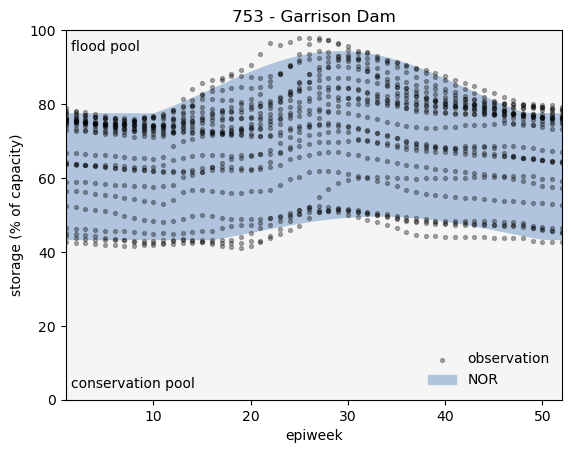

In [148]:
# plot storage
fig, ax = plt.subplots()
ax.scatter(weekly_storage.epiweek, weekly_storage.s_pct, c='k', s=8, alpha=0.3, label='observation')
ax.fill_between(NOR.index, NOR.flood, 100, color='whitesmoke', zorder=0)
ax.fill_between(NOR.index, NOR.conservation, NOR.flood, color='lightsteelblue', zorder=0, label='NOR')
ax.fill_between(NOR.index, 0, NOR.conservation, color='whitesmoke', zorder=0)
ax.set_title('{0} - {1}'.format(*attributes.loc[dam_id, ['GRAND_ID', 'DAM_NAME']]))
ax.text(0.01, 0.975, 'flood pool', va='top', transform=ax.transAxes)
ax.text(0.01, 0.025, 'conservation pool', va='bottom', transform=ax.transAxes)
ax.legend(loc=4, frameon=False)
ax.set(xlim=(1, 52),
       xlabel='epiweek',
       ylim=(0, 100),
       ylabel='storage (% of capacity)');

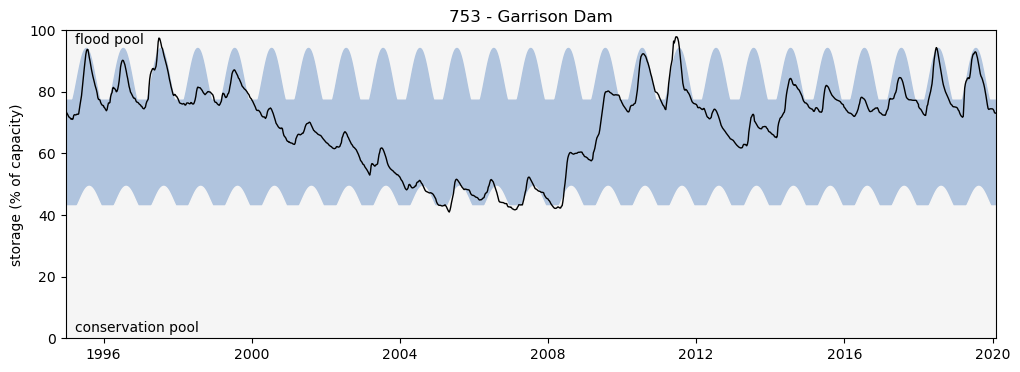

In [149]:
# plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(weekly.s_pct, c='k', lw=1)
ax.fill_between(weekly_storage.index, weekly_storage.flood, 100, color='whitesmoke', zorder=0)
ax.fill_between(weekly_storage.index, weekly_storage.conservation, weekly_storage.flood, color='lightsteelblue', zorder=0)
ax.fill_between(weekly_storage.index, 0, weekly_storage.conservation, color='whitesmoke', zorder=0)
ax.set_title('{0} - {1}'.format(*attributes.loc[dam_id, ['GRAND_ID', 'DAM_NAME']]))
ax.text(0.01, 0.99, 'flood pool', va='top', transform=ax.transAxes)
ax.text(0.01, 0.01, 'conservation pool', va='bottom', transform=ax.transAxes)
ax.set(xlim=(weekly.index.min(), weekly.index.max()),
       ylim=(0, 100),
       ylabel='storage (% of capacity)');

In [150]:
# export parameters of the storage harmonics
path_nor = Path('./NOR/')
path_nor.mkdir(parents=True, exist_ok=True)
pd.DataFrame({
            'pf': model_storage["NSR upper bound"],
            'pm': model_storage["NSR lower bound"]
        }).to_csv(path_nor / f'{dam_id}.csv')

### Release function

In [152]:
# fit release model
model_release = fit_release_function(dam_id, USRDATS_path, GRanD_path, targets_path=path_nor, cutoff_year=cutoff_year)

# for key, value in model_release.items():
#     print(key)
#     print(value)
#     print()

Fitting release function for dam 753: Garrison Dam
Release residual model will be discarded; (release will be based harmonic function only)


In [153]:
# extract info from the fitted release: average inflow, harmonic release (standardised) and release contraints
avg_inflow = model_release['mean inflow from obs. (MCM / wk)']
release_harmonic = convert_parameters_to_release_harmonic(model_release['harmonic parameters']).set_index('epiweek').squeeze()
Qmin, Qmax = (model_release['constraints'] + 1) * avg_inflow

In [154]:
# combine weekly obaserved and harmonic releases
weekly_release = (model_release['weekly release']
      .merge(avg_inflow * (release_harmonic + 1), on='epiweek')
      )
weekly_release.sort_values(['year', 'epiweek'], inplace=True)
weekly_release['date'] = weekly_release.apply(lambda row: epiweek_to_date(row['year'], row['epiweek']), axis=1)
weekly_release.set_index('date', inplace=True)

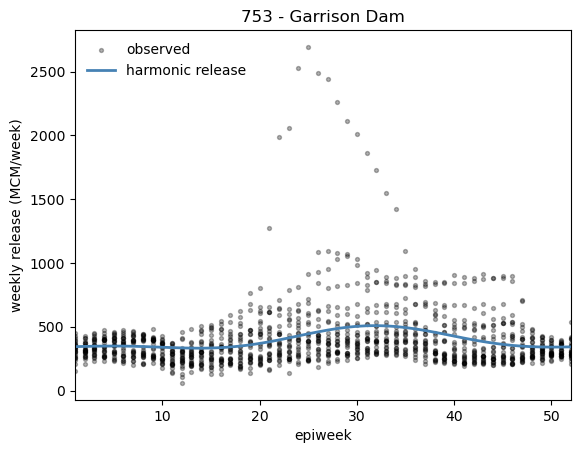

In [156]:
fig, ax = plt.subplots()
# ax.scatter(release['weekly release'].epiweek, release['weekly release'].i, c='orange', s=8, alpha=0.3, label='obs. inflow')
ax.scatter(weekly_release.epiweek, weekly_release.r, c='k', s=8, alpha=0.3, label='observed')
ax.plot(release_harmonic.index, avg_inflow * (release_harmonic + 1), c='steelblue', lw=2, label='harmonic release')
ax.set_title('{0} - {1}'.format(*attributes.loc[dam_id, ['GRAND_ID', 'DAM_NAME']]))
ax.legend(loc=2, frameon=False)
ax.set(xlim=(1, 52),
       xlabel='epiweek',
       ylabel='weekly release (MCM/week)'
      );

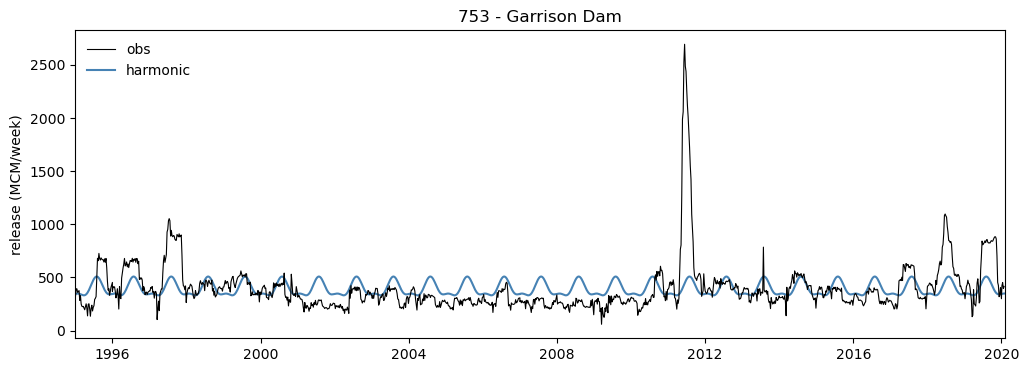

In [157]:
# plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(weekly_release.r, c='k', lw=.8, label='obs')
ax.plot(weekly_release.release_harmonic, color='steelblue', zorder=0, label='harmonic')
ax.set_title('{0} - {1}'.format(*attributes.loc[dam_id, ['GRAND_ID', 'DAM_NAME']]))
ax.legend(loc=2, frameon=False)
ax.set(xlim=(weekly.index.min(), weekly.index.max()),
       ylabel='release (MCM/week)');

In [193]:
from typing import List, Optional

class Starfit():
    
    def __init__(self,
                 Vtot: float,
                 avg_inflow: float,
                 pars_Vf: List,
                 pars_Vc: List,
                 pars_Qharm: List,
                 pars_Qresid: List,
                 Qmin: float,
                 Qmax: float):
        """
        """
        
        self.Vtot = Vtot
        self.avg_inflow = avg_inflow
        self.NOR = pd.concat((convert_parameters_to_targets(pars_Vf, 'flood').set_index('epiweek'),
                              convert_parameters_to_targets(pars_Vc, 'conservation').set_index('epiweek')),
                             axis=1)
        self.NOR /= 100
        self.Qharm = convert_parameters_to_release_harmonic(pars_Qharm).set_index('epiweek').squeeze()
        self.parsQresid = pars_Qresid
        self.Qmin = Qmin
        self.Qmax = Qmax
        
    def timestep(self, 
                 I: float,
                 V: float,
                 epiweek: int
                ) -> List[float]:
        """Given an inflow and an initial storage values, it computes the corresponding outflow and storage at the end of the timestep
        
        Parameters:
        -----------
        I: float
            Inflow (hm3/week)
        V: float
            Volume stored in the reservoir (hm3)
        epiweek: integer
            Week of the year. It must be a value between 1 and 52
            
        Returns:
        --------
        Q, V: List[float]
            Outflow (hm3/week) and updated storage (hm3)
        """
        
        # standardised inputs
        I_st = I / self.avg_inflow - 1
        V_st = V / self.Vtot
        
        # flood/conservation storage that week
        assert 1 <= epiweek <=52, f'"epiweek" must be a value between 1 and 52 (including both): {epiweek} was provided'
        Vf, Vc = self.NOR.loc[epiweek]
        
        # compute release
        if V_st < Vc:
            Q = self.Qmin
        elif Vc <= V_st <= Vf:
            # harmonic component of the release
            harm = self.Qharm[epiweek]
            # residual component of the release
            A_t = (V_st - Vc) / (Vf - Vc) # storage availability
            eps = self.parsQresid[0] + A_t * self.parsQresid[1] + I_st * self.parsQresid[2]      
            # release
            Q = min(self.avg_inflow * (harm + eps + 1), self.Qmax)
        elif V_st > Vf:
            Q = min(self.Vtot * (V_st - Vf) + I, self.Qmax)

        # ensure mass conservation
        Q = max(min(Q, I + V), I + V - self.Vtot)
        
        # update storage
        V += I - Q
        
        return Q, V
    
    def simulate(self,
                 inflow: pd.Series,
                 Vo: Optional[float ] = None,
                 demand: Optional[pd.Series] = None,
                ) -> pd.DataFrame:
        """Given an inflow time series (m3/s) and an initial storage (m3), it computes the time series of outflow (m3/s) and storage (m3)
        
        Parameters:
        -----------
        inflow: pd.Series
            Time series of flow coming into the reservoir (m3/s)
        Vo: float (optional)
            Initial value of reservoir storage (m3). If not provided, it is assumed that the normal storage is the initial condition
        demand: pandas.Series (optional)
            Time series of total water demand
            
        Returns:
        --------
        pd.DataFrame
            A table that concatenates the storage, inflow and outflow time series.
        """
        
        if Vo is None:
            Vo = .5 * self.Vtot
        
        if demand is not None and not isinstance(demand, pd.Series):
            raise ValueError('"demand" must be a pandas Series representing a time series of water demand.')
            
        inflow.name = 'inflow'
        storage = pd.Series(index=inflow.index, dtype=float, name='storage')
        outflow = pd.Series(index=inflow.index, dtype=float, name='outflow')
        for date, I in inflow.iteritems():
            epiweek = min(date.isocalendar().week, 52)
            storage[date] = Vo
            # compute outflow and new storage
            if demand is None:
                Q, V = self.timestep(I, Vo, epiweek)
            else:
                Q, V = self.timestep(inflow[ts], Vo, demand[ts])
            outflow[date] = Q
            # update current storage
            Vo = V
                
        return pd.concat((storage, inflow, outflow), axis=1)

In [194]:
res = Starfit(Vtot,
              avg_inflow=avg_inflow,
              pars_Vf=model_storage['NSR upper bound'],
              pars_Vc=model_storage['NSR lower bound'],
              pars_Qharm=model_release['harmonic parameters'],
              pars_Qresid=model_release['residual parameters'],
              Qmin=Qmin,
              Qmax=Qmax
             )

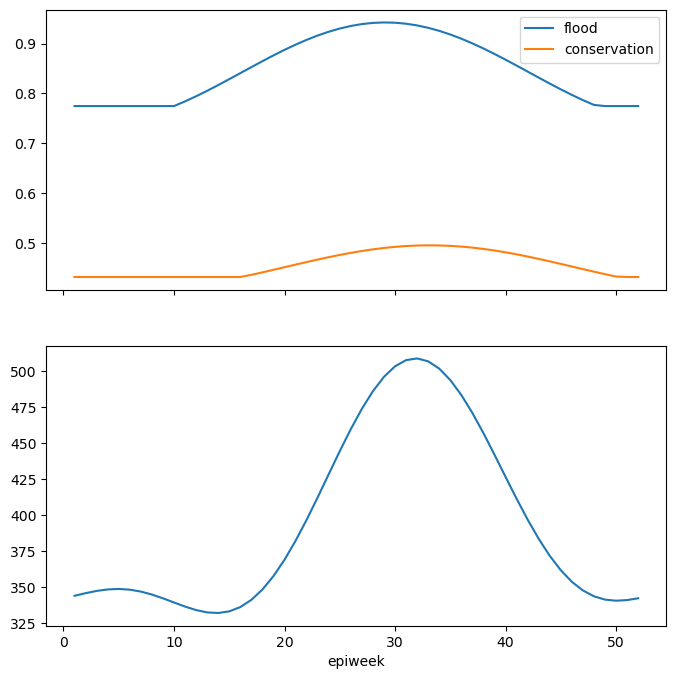

In [195]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)
res.NOR.plot(ax=ax[0]);
((res.Qharm + 1) * res.avg_inflow).plot(ax=ax[1]);

In [197]:
sim = res.simulate(weekly_release.i, weekly_release.s_start.iloc[0])

In [198]:
sim.head()

,storage,inflow,outflow
date,,,
1994-12-26,22408.631000,154.134317,342.302161
1995-01-02,22220.463156,156.580819,344.023958
1995-01-09,22033.020017,293.588928,345.832564
1995-01-16,21980.776381,232.424726,347.395437
1995-01-23,21865.805670,259.337030,348.438830


In [202]:
weekly_storage

,year,epiweek,s_pct,flood,conservation
date,,,,,
1994-12-26,1995,1,73.95,77.459,43.115
1995-01-02,1995,2,73.23,77.459,43.115
1995-01-09,1995,3,72.86,77.459,43.115
1995-01-16,1995,4,72.42,77.459,43.115
1995-01-23,1995,5,71.88,77.459,43.115
...,...,...,...,...,...
2020-01-06,2020,2,74.34,77.459,43.115
2020-01-13,2020,3,74.00,77.459,43.115
2020-01-20,2020,4,73.29,77.459,43.115


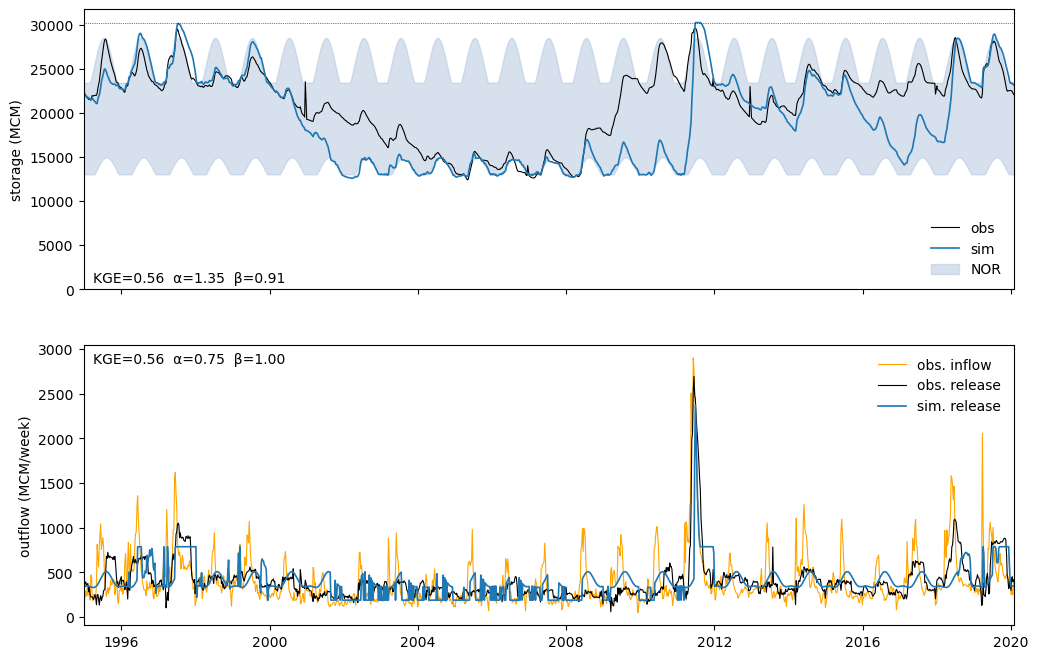

In [234]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

ax = axes[0]
ax.plot(weekly_release.s_start, c='k', lw=.8, label='obs')
ax.plot(sim.storage, lw=1.2, label='sim')
ax.fill_between(weekly_storage.index,
                res.Vtot * weekly_storage.conservation / 100,
                res.Vtot * weekly_storage.flood / 100,
                color='lightsteelblue',
                alpha=.5, 
                label='NOR')
ax.axhline(res.Vtot, c='k', ls=':', lw=.5)
kge, alpha, beta, corr = KGEmod(weekly_release.s_start, sim.storage)
text = f'KGE={kge:.2f}  α={alpha:.2f}  β={beta:.2f}'
ax.text(0.01, 0.025, text, transform=ax.transAxes)
ax.legend(loc=4, frameon=False)
ax.set(xlim=(sim.index.min(), sim.index.max()),
       ylim=(0, res.Vtot * 1.05),
       ylabel='storage (MCM)');

ax = axes[1]
ax.plot(sim.inflow, c='orange', lw=.8, label='obs. inflow')
ax.plot(weekly_release.r, c='k', lw=.8, label='obs. release')
ax.plot(sim.outflow, lw=1.2, label='sim. release')
kge, alpha, beta, corr = KGEmod(weekly_release.r, sim.outflow)
text = f'KGE={kge:.2f}  α={alpha:.2f}  β={beta:.2f}'
ax.text(0.01, 0.975, text, va='top', transform=ax.transAxes)
ax.legend(loc=1, frameon=False)
ax.set(ylabel='outflow (MCM/week)');